In [1]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [91]:
#import models.qp as model # 1/PBR + GP/A
#import models.ncav as model # NCAV
import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model
#import models.lu_zhang as model

importlib.reload(model)

<module 'models.super_value' from '/Users/seunghun/Documents/Projects/stock-backtesting/backtest-playground/quantitative-value/models/super_value.py'>

In [92]:
MODEL_NAME = 'qp'
DATA_DIR = '../data/quarterly/3-6-9-12' # quarter
# DATA_DIR = '../data/half-year/2-8' # half year
# DATA_DIR = '../data/daily/8-1'
REBALANCE = 4 # 1: yearly, 2: half-yearly 4: quarterly

In [93]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [94]:
df_account

,start_date,end_date,filepath
0,2002-03-01,2002-06-03,../data/quarterly/3-6-9-12/2002-03-01.csv
1,2002-06-03,2002-09-02,../data/quarterly/3-6-9-12/2002-06-03.csv
2,2002-09-02,2002-12-02,../data/quarterly/3-6-9-12/2002-09-02.csv
3,2002-12-02,2003-03-03,../data/quarterly/3-6-9-12/2002-12-02.csv
4,2003-03-03,2003-06-02,../data/quarterly/3-6-9-12/2003-03-03.csv
...,...,...,...
66,2018-09-03,2018-12-03,../data/quarterly/3-6-9-12/2018-09-03.csv
67,2018-12-03,2019-03-01,../data/quarterly/3-6-9-12/2018-12-03.csv
68,2019-03-01,2019-06-03,../data/quarterly/3-6-9-12/2019-03-01.csv
69,2019-06-03,2019-09-02,../data/quarterly/3-6-9-12/2019-06-03.csv


In [95]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, False), axis=1)

/Users/seunghun/Documents/Projects/stock-backtesting/backtest-playground/quantitative-value/common.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['black'] = df.apply(lambda x: corp_name_has_black(x[col]), axis=1)


2002-03-01 선정 기업 수 30
2002-06-03 선정 기업 수 30
2002-09-02 선정 기업 수 30
2002-12-02 선정 기업 수 30
2003-03-03 선정 기업 수 30
2003-06-02 선정 기업 수 30
2003-09-01 선정 기업 수 30
2003-12-01 선정 기업 수 30
2004-03-01 선정 기업 수 30
2004-06-01 선정 기업 수 30
2004-09-01 선정 기업 수 30
2004-12-01 선정 기업 수 30
2005-03-01 선정 기업 수 30
2005-06-01 선정 기업 수 30
2005-09-01 선정 기업 수 30
2005-12-01 선정 기업 수 30
2006-03-01 선정 기업 수 30
2006-06-01 선정 기업 수 30
2006-09-01 선정 기업 수 30
2006-12-01 선정 기업 수 30
2007-03-01 선정 기업 수 30
2007-06-01 선정 기업 수 30
2007-09-03 선정 기업 수 30
2007-12-03 선정 기업 수 30
2008-03-03 선정 기업 수 30
2008-06-02 선정 기업 수 30
2008-09-01 선정 기업 수 30
2008-12-01 선정 기업 수 30
2009-03-02 선정 기업 수 30
2009-06-01 선정 기업 수 30
2009-09-01 선정 기업 수 30
2009-12-01 선정 기업 수 30
2010-03-01 선정 기업 수 30
2010-06-01 선정 기업 수 30
2010-09-01 선정 기업 수 30
2010-12-01 선정 기업 수 30
2011-03-01 선정 기업 수 30
2011-06-01 선정 기업 수 30
2011-09-01 선정 기업 수 30
2011-12-01 선정 기업 수 30
2012-03-01 선정 기업 수 30
2012-06-01 선정 기업 수 30
2012-09-03 선정 기업 수 30
2012-12-03 선정 기업 수 30
2013-03-01 선정 기업 수 30
2013-06-03

In [96]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')
df_account['delisted'] = 0
df_account['delisted_stocks'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률, 상장폐지 기업 수를 구한다.
        delisted = 0 # 상장폐지 기업 수
        delisted_stocks  = []
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) 
                end_price = end_price.iloc[0]
                
            if end_price == 0: # 가격 정보가 없을 경우 상폐
                delisted += 1
                delisted_stocks.append(stock)
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        df_account.at[i, 'delisted'] = delisted
        df_account.at[i, 'delisted_stocks'] = delisted_stocks
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

2002-03-01 ~ 2002-06-03 : 1.1716597761359162
2002-06-03 ~ 2002-09-02 : 0.9741544802288865
2002-09-02 ~ 2002-12-02 : 0.9190174465407634
2002-12-02 ~ 2003-03-03 : 0.9487809902706374
2003-03-03 ~ 2003-06-02 : 1.1238260362824741
2003-06-02 ~ 2003-09-01 : 0.9778651646994256
2003-09-01 ~ 2003-12-01 : 0.9005500913954954
2003-12-01 ~ 2004-03-01 : 0.9411491184120699
2004-03-01 ~ 2004-06-01 : 1.0384733698606459
2004-06-01 ~ 2004-09-01 : 1.0636461151758516
2004-09-01 ~ 2004-12-01 : 1.0475384337086808
2004-12-01 ~ 2005-03-01 : 1.5672013925666906
2005-03-01 ~ 2005-06-01 : 1.0253394553338164
2005-06-01 ~ 2005-09-01 : 1.2593315815502257
2005-09-01 ~ 2005-12-01 : 1.4978581154440958
2005-12-01 ~ 2006-03-01 : 1.0524425884964392
2006-03-01 ~ 2006-06-01 : 0.9749274061562687
2006-06-01 ~ 2006-09-01 : 1.0248832337638316
2006-09-01 ~ 2006-12-01 : 1.1693465020235998
2006-12-01 ~ 2007-03-01 : 1.072943328292553
2007-03-01 ~ 2007-06-01 : 1.326150147515569
2007-06-01 ~ 2007-09-03 : 1.101690475851947
2007-09-03 ~ 

In [97]:
df_account['total'] = df_account['yield'].cumprod()

In [98]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/((i+1)/REBALANCE))

In [99]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,delisted,delisted_stocks,total,cagr
0,2002-03-01,2002-06-03,../data/quarterly/3-6-9-12/2002-03-01.csv,"[013360, 000850, 007110, 021820, 001810, 03589...",1.171660,"[0.9214659685863874, 0.8259887005649718, 1.374...",0,[],1.171660,1.884543
1,2002-06-03,2002-09-02,../data/quarterly/3-6-9-12/2002-06-03.csv,"[021820, 005610, 002360, 017480, 000850, 02588...",0.974154,"[0.7836538461538461, 1.2941176470588236, 0.992...",0,[],1.141378,1.302743
2,2002-09-02,2002-12-02,../data/quarterly/3-6-9-12/2002-09-02.csv,"[021820, 011420, 000850, 017480, 002360, 02588...",0.919017,"[0.9938650306748467, 0.9229508196721311, 0.929...",0,[],1.048946,1.065788
3,2002-12-02,2003-03-03,../data/quarterly/3-6-9-12/2002-12-02.csv,"[022220, 021820, 011420, 000850, 013360, 00229...",0.948781,"[0.0, 0.8382716049382716, 0.8348134991119005, ...",1,[022220],0.995220,0.995220
4,2003-03-03,2003-06-02,../data/quarterly/3-6-9-12/2003-03-03.csv,"[021820, 000850, 011420, 011560, 001840, 02483...",1.123826,"[1.1782032400589102, 1.1265060240963856, 0.902...",0,[],1.118454,1.093691
...,...,...,...,...,...,...,...,...,...,...
66,2018-09-03,2018-12-03,../data/quarterly/3-6-9-12/2018-09-03.csv,"[140290, 253590, 170030, 081580, 214330, 09338...",0.878449,"[0.8079268292682927, 0.920704845814978, 0.7984...",1,[239340],74.109135,1.293106
67,2018-12-03,2019-03-01,../data/quarterly/3-6-9-12/2018-12-03.csv,"[140290, 170030, 253590, 093380, 083450, 08158...",1.129518,"[0.6943396226415094, 1.1676528599605522, 0.813...",0,[],83.707588,1.297489
68,2019-03-01,2019-06-03,../data/quarterly/3-6-9-12/2019-03-01.csv,"[140290, 170030, 224810, 123700, 083450, 12664...",0.987441,"[0.7663043478260869, 1.0456081081081081, 1.434...",0,[],82.656341,1.291655
69,2019-06-03,2019-09-02,../data/quarterly/3-6-9-12/2019-06-03.csv,"[076340, 012620, 081580, 208890, 039240, 09259...",1.001065,"[0.8138138138138138, 0.9385775862068966, 0.951...",1,[208890],82.744343,1.287019


In [100]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [101]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [102]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

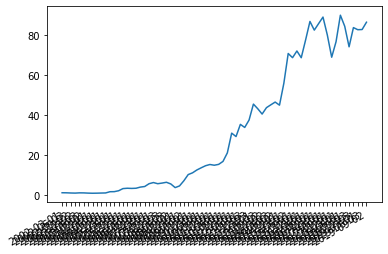

In [103]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [104]:
cagrs = df_account['cagr']
rolling_cagrs = []
ROLLING = 3
for i in range(len(cagrs)):
    if i - 3 < 0:
        rolling_cagr = np.mean(cagrs[0:i])
    else:
        rolling_cagr = np.mean(cagrs[i - 3:i])
    rolling_cagrs.append(rolling_cagr)

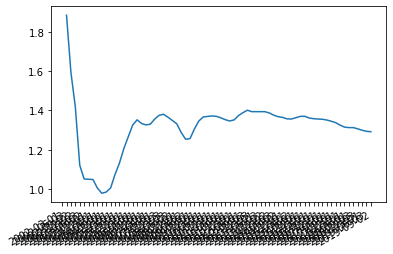

In [105]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], rolling_cagrs, marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [106]:
# 가격 정보가 없는 경우 상폐로 처리했음. 실제로 상폐까지는 아니고 거래정지인 경우가 있음
delisted_stocks = sum(df_account['delisted'])

In [107]:
cagr = pow(df_account['total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))

In [108]:
# MDD, MDD duration 구하기
max_yield = -100.0
min_yield = 0.0
mdd = 0.0
mdd_duration = 0 

dd = 0.0
dd_duration = 0
for val in df_account['total']:
    if val > max_yield:
        max_yield = val
        min_yield = val
        dd_duration = 0
        continue
    
    if val < min_yield:
        min_yield = val
        dd = (1.0 - min_yield / max_yield) * 100.0
        dd_duration += 1
        
        if dd > mdd:
            mdd = dd
        if dd_duration > mdd_duration:
            mdd_duration = dd_duration
            
if REBALANCE == 2:
    mdd_duration *= 6
elif REBALANCE == 4:
    mdd_duration *= 3

In [109]:
# 수익률 표준편차 구하기
filetered_yield = list(df_account['yield']).copy()

# outlier 제거
filetered_yield.remove(max(filetered_yield))
filetered_yield.remove(min(filetered_yield))

std_yield = statistics.stdev(filetered_yield)

In [110]:
# 평균 승률 
yields = []
for i in range(len(df_account)):
    yields.extend(df_account.iloc[i]['yields'])
    
win_rate = (sum([val > 1.0 for val in yields]) / len(yields)) * 100.0

In [111]:
t = PrettyTable(['Rebalance', 'CAGR', 'MDD', 'MDD duration', 'STD', 'Delisted', 'Win rate', 'Note'])
t.add_row([os.path.basename(DATA_DIR),
           "%.2f%%" % ((cagr - 1.0) * 100.0),
           "%.2f%%" % (mdd),
           mdd_duration,
           "%.4f" % std_yield,
           delisted_stocks,
           "%.2f%%" % win_rate,
           ""
          ])
print(t)

+-----------+--------+--------+--------------+--------+----------+----------+------+
| Rebalance |  CAGR  |  MDD   | MDD duration |  STD   | Delisted | Win rate | Note |
+-----------+--------+--------+--------------+--------+----------+----------+------+
|  3-6-9-12 | 28.56% | 41.60% |      15      | 0.1475 |    26    |  54.23%  |      |
+-----------+--------+--------+--------------+--------+----------+----------+------+


In [112]:
# 수수료 고려
df_account['fee_yield'] = df_account['yield'] * 0.99
df_account['fee_total'] = df_account['fee_yield'].cumprod()
pow(df_account['fee_total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))

1.234917406467772